## Descripción de las Variables de Entrada.

`CustomerID`: Identificador único para cada cliente.

`Gender`: Género.

`Age`: Edad.

`Annual Income (k$)`: Ingresos anuales.

`Spending Score (1-100)`: Índice de gastos.

## Importación de librerías.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

Cargamos el CSV

In [2]:
df = pd.read_csv("Mall_Customers.csv")

## EDA o análisis exploratorio de datos.

In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Buscamos valores nulos

<Axes: >

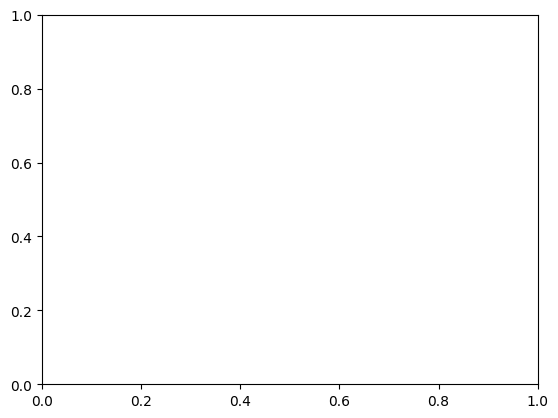

In [5]:
sns.barplot(df.drop(df.dropna(axis=1).columns, axis=1).isna().mean())


"Dividimos" los datos por género

In [6]:
df = pd.get_dummies(df, columns=['Gender'])

In [7]:
df.head(5)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,False,True
1,2,21,15,81,False,True
2,3,20,16,6,True,False
3,4,23,16,77,True,False
4,5,31,17,40,True,False


Empezamos a graficar buscando información valiosa.

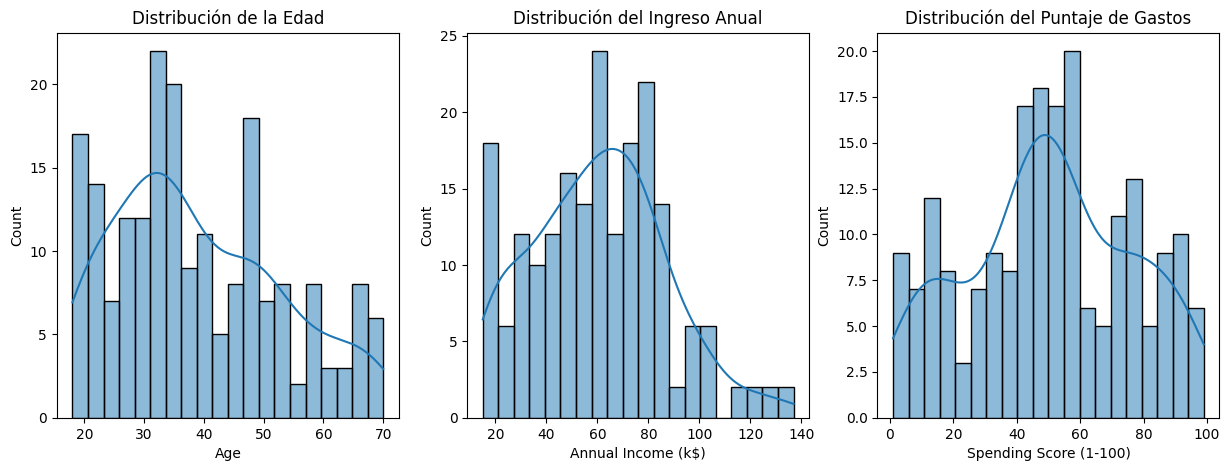

In [8]:
# Histogramas para variables numéricas
plt.figure(figsize=[15,5])
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Distribución de la Edad')

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], kde=True, bins=20)
plt.title('Distribución del Ingreso Anual')

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], kde=True, bins=20)
plt.title('Distribución del Puntaje de Gastos')
plt.show()


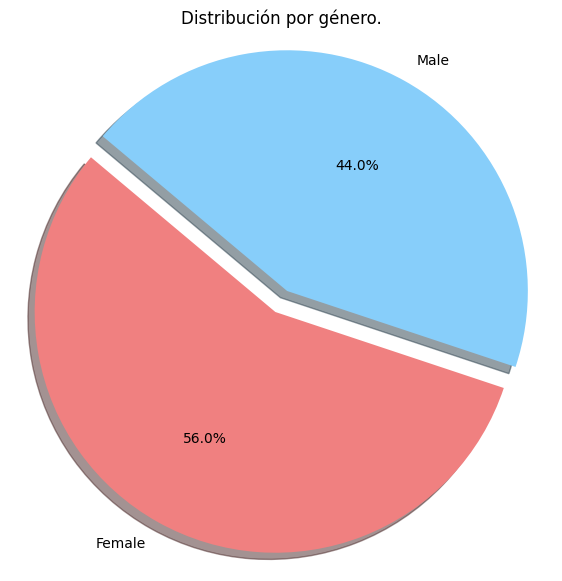

In [9]:
num_female = df['Gender_Female'].sum()  
num_male = df['Gender_Male'].sum()     

labels = 'Female', 'Male'

sizes = [num_female, num_male]

colors = ['lightcoral', 'lightskyblue']

explode = (0.1, 0)  

plt.figure(figsize=[7,7])
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Distribución por género.')
plt.show()

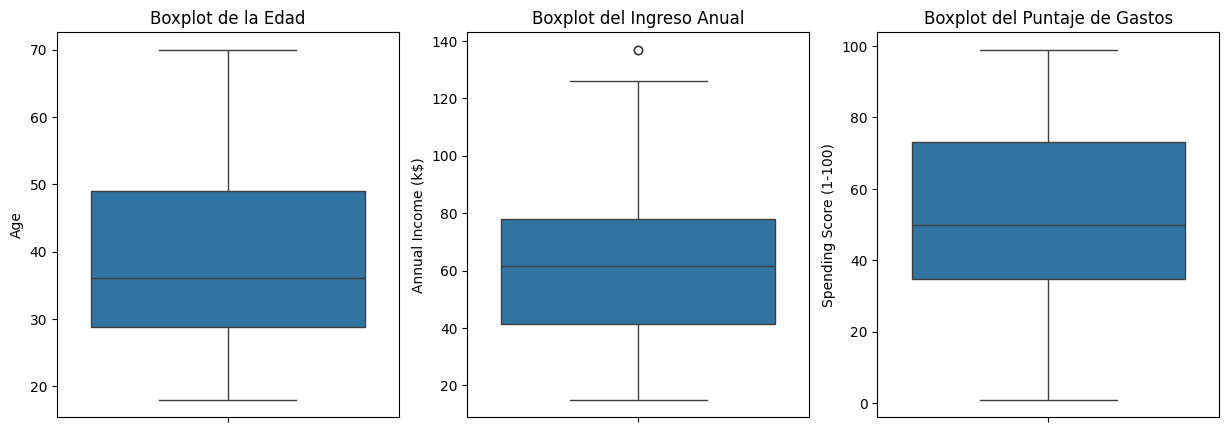

In [10]:
# Boxplots para detectar valores atípicos
plt.figure(figsize=[15,5])
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age'])
plt.title('Boxplot de la Edad')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Annual Income (k$)'])
plt.title('Boxplot del Ingreso Anual')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Spending Score (1-100)'])
plt.title('Boxplot del Puntaje de Gastos')
plt.show()


Hacemos 3 gráficas de distrubución de datos.

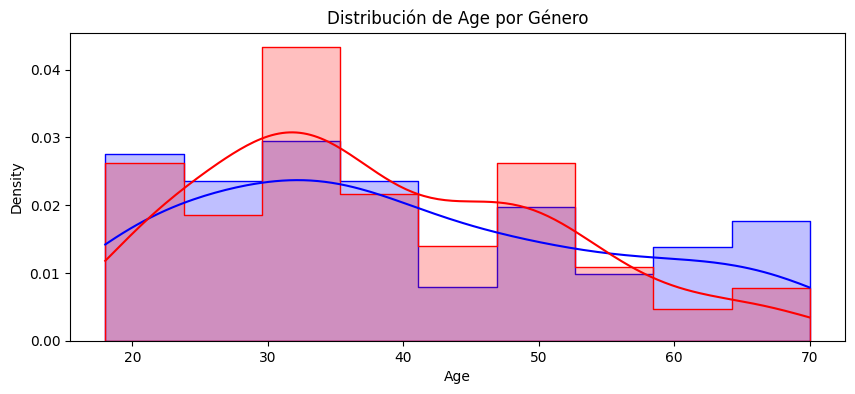

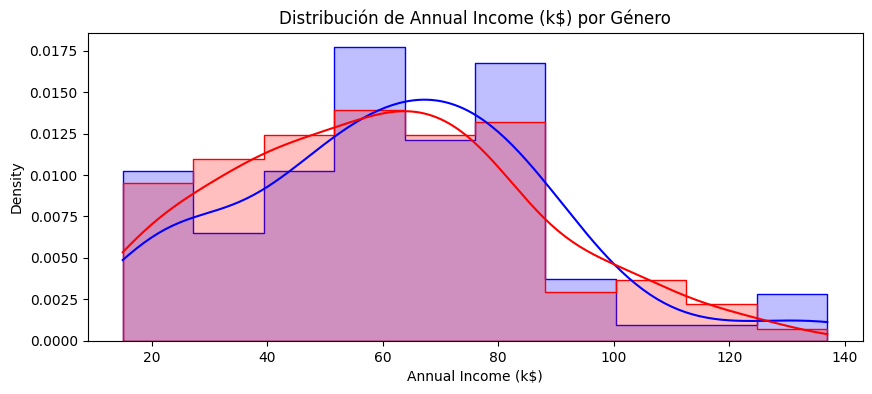

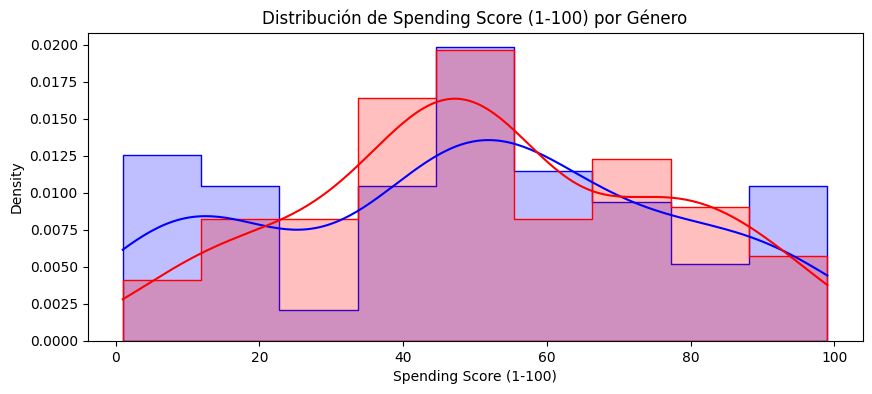

In [11]:
# Definir las características a visualizar.
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Asignar colores manualmente para claridad.
color_map = {0: 'red', 1: 'blue'}  # 0 para mujer y 1 para hombres.

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=feature, hue="Gender_Male", palette=color_map, kde=True, element="step", stat="density", common_norm=False, legend=None)
    plt.title(f'Distribución de {feature} por Género')
    plt.show()


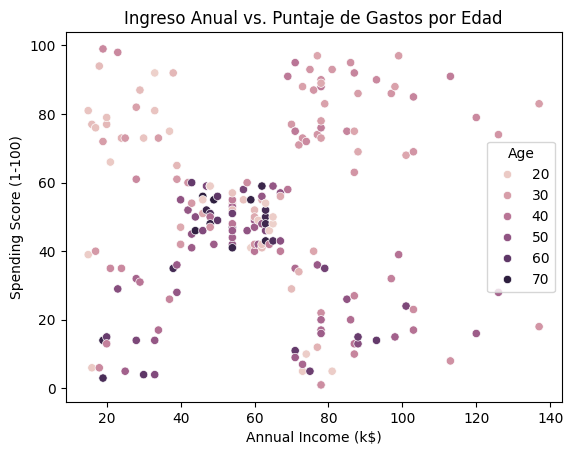

In [12]:
# Gráficos de dispersión entre Ingresos Anuales y Puntaje de Gastos
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age')
plt.title('Ingreso Anual vs. Puntaje de Gastos por Edad')
plt.show()


In [13]:
df.columns

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_Female', 'Gender_Male'],
      dtype='object')

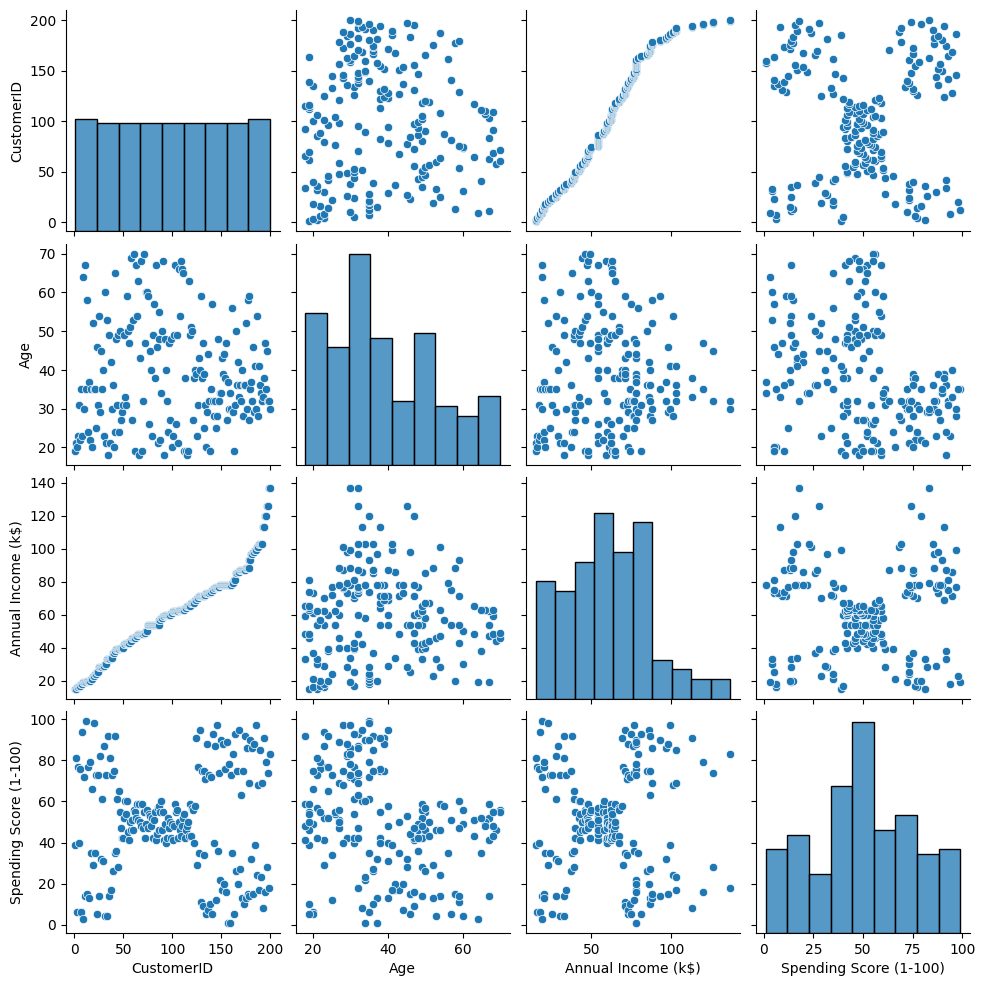

In [14]:
# Gráfico de pares para todas las características
sns.pairplot(df, vars=['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
plt.show()

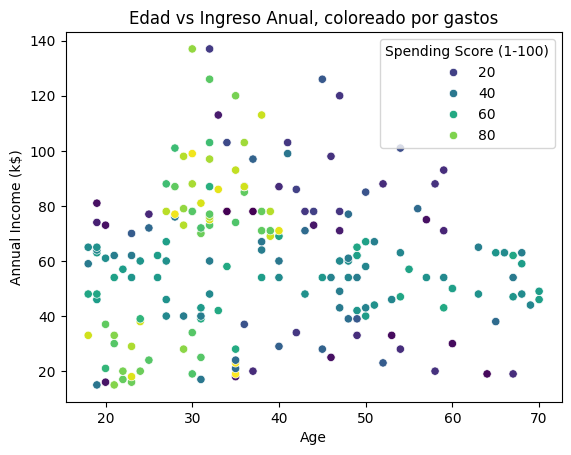

In [15]:
# Usamos un gráfico de dispersión pero esta vez comparando Edad con Ingreso Anual
sns.scatterplot(data=df, x='Age', y='Annual Income (k$)', hue='Spending Score (1-100)', palette='viridis')
plt.title('Edad vs Ingreso Anual, coloreado por gastos')
plt.show()


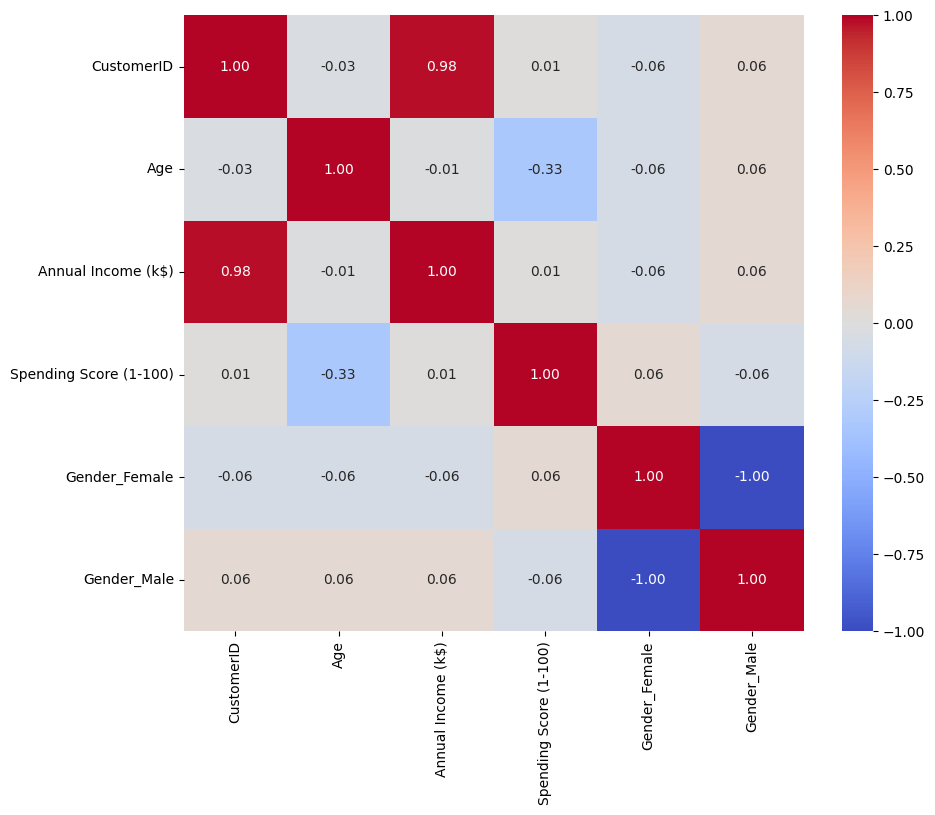

In [16]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


Creación de tres columnas nuevas: Age_Group, Income_Level y Spending_level. 

`Age_Group`: Al igual que la columna Age, es la edad, pero la categorizamos.

`Income_Level`: Al igual que la columna Annual_Income, pero también la categorizamos.

`Spending_level`: Y como no podía ser de otra forma, la columna Spending_Level también la hacemos categoría.

In [17]:
# Asegurándonos de que los bins cubran todos los valores posibles
bins_age = [17, 31, 60, df['Age'].max() + 1]  
labels_age = ['Young', 'Adult', 'Elder']
df['Age_Group'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=False)  

# Ajustando bins para 'Annual Income (k$)' para asegurar cobertura completa
bins_income = [-np.inf, np.percentile(df['Annual Income (k$)'], 33), np.percentile(df['Annual Income (k$)'], 66), np.inf]
labels_income = ['Low', 'Medium', 'High']
df['Income_Level'] = pd.cut(df['Annual Income (k$)'], bins=bins_income, labels=labels_income)

# Ajustando bins para 'Spending Score (1-100)' para asegurar cobertura completa
bins_spending = [-np.inf, np.percentile(df['Spending Score (1-100)'], 33), np.percentile(df['Spending Score (1-100)'], 66), np.inf]
labels_spending = ['Low', 'Medium', 'High']
df['Spending_Level'] = pd.cut(df['Spending Score (1-100)'], bins=bins_spending, labels=labels_spending)

# Verificar nuevamente los cambiosDes
df.head()


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,Age_Group,Income_Level,Spending_Level
0,1,19,15,39,False,True,Young,Low,Low
1,2,21,15,81,False,True,Young,Low,High
2,3,20,16,6,True,False,Young,Low,Low
3,4,23,16,77,True,False,Young,Low,High
4,5,31,17,40,True,False,Adult,Low,Low


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    int64   
 1   Age                     200 non-null    int64   
 2   Annual Income (k$)      200 non-null    int64   
 3   Spending Score (1-100)  200 non-null    int64   
 4   Gender_Female           200 non-null    bool    
 5   Gender_Male             200 non-null    bool    
 6   Age_Group               200 non-null    category
 7   Income_Level            200 non-null    category
 8   Spending_Level          200 non-null    category
dtypes: bool(2), category(3), int64(4)
memory usage: 7.7 KB


Aplicamos un metodo en las nuevas columnas catégoricas y creamos nuevas columnas con valor 0 y 1. 

`get_dummies`

In [19]:
dummies = pd.get_dummies(df[['Age_Group', 'Income_Level', 'Spending_Level']])
# Unimos las variables dummy con tus datos originales
df_model = pd.concat([df, dummies], axis=1)
# Eliminamos las columnas originales categóricas si lo deseas
df_model.drop(['Annual Income (k$)', 'Spending Score (1-100)', 'Age_Group', 'Income_Level', 'Spending_Level'], axis=1, inplace=True)


In [20]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CustomerID             200 non-null    int64
 1   Age                    200 non-null    int64
 2   Gender_Female          200 non-null    bool 
 3   Gender_Male            200 non-null    bool 
 4   Age_Group_Young        200 non-null    bool 
 5   Age_Group_Adult        200 non-null    bool 
 6   Age_Group_Elder        200 non-null    bool 
 7   Income_Level_Low       200 non-null    bool 
 8   Income_Level_Medium    200 non-null    bool 
 9   Income_Level_High      200 non-null    bool 
 10  Spending_Level_Low     200 non-null    bool 
 11  Spending_Level_Medium  200 non-null    bool 
 12  Spending_Level_High    200 non-null    bool 
dtypes: bool(11), int64(2)
memory usage: 5.4 KB


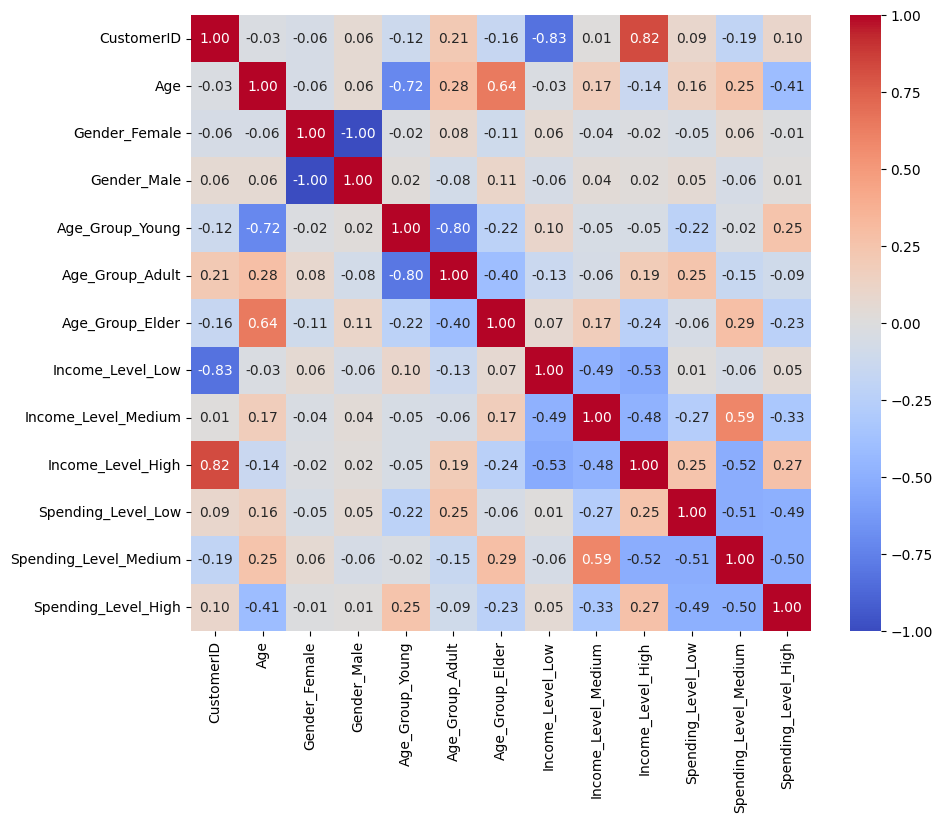

In [21]:
plt.figure(figsize=(10, 8))
corr_matrix = df_model.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [22]:
df_model.columns

Index(['CustomerID', 'Age', 'Gender_Female', 'Gender_Male', 'Age_Group_Young',
       'Age_Group_Adult', 'Age_Group_Elder', 'Income_Level_Low',
       'Income_Level_Medium', 'Income_Level_High', 'Spending_Level_Low',
       'Spending_Level_Medium', 'Spending_Level_High'],
      dtype='object')

## Machine learning

Y empieza la magia. 

Vamos a realizar un proyecto de clustering o segmentación sobre la BBDD de los clientes.

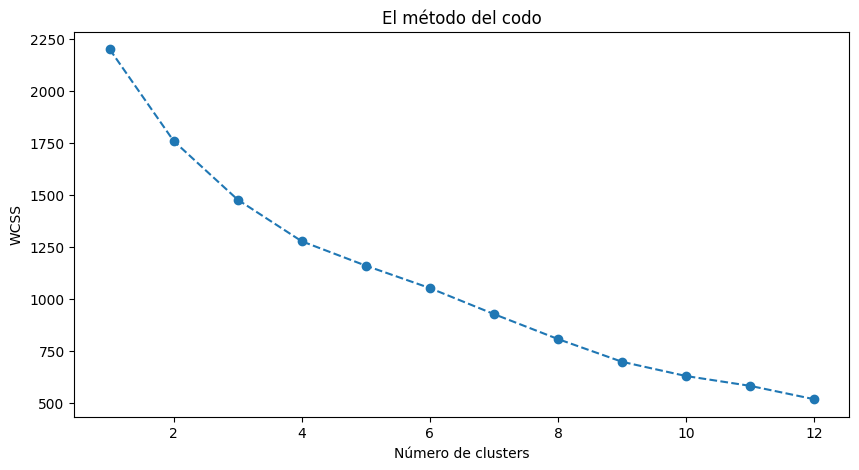

In [23]:
# Asegúrate de que X_scaled contiene todas las características que quieres incluir
X = df_model[['Gender_Female', 'Gender_Male', 'Age_Group_Young', 'Age_Group_Adult',
            'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
            'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
            'Spending_Level_High']]

# Normalizando las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determinando el número óptimo de clusters
wcss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 13), wcss, marker='o', linestyle='--')
plt.title('El método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


In [24]:
# Aplicando K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init='auto', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Agregando la asignación de clusters al DataFrame original para análisis
df_model['Cluster'] = y_kmeans

# Verificando el tamaño de cada cluster
print(df_model['Cluster'].value_counts())

# Explorando las características promedio de cada cluster en df_model
for i in range(7):
    print(f"\nCluster {i} characteristics:")
    # Selecciona solo las columnas numéricas antes de calcular la media para evitar errores
    print(df_model[df_model['Cluster'] == i].select_dtypes(include=[np.number]).mean())


Cluster
2    38
6    33
1    30
0    29
3    25
4    24
5    21
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID    103.379310
Age            45.137931
Cluster         0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID    167.100000
Age            38.766667
Cluster         1.000000
dtype: float64

Cluster 2 characteristics:
CustomerID    75.263158
Age           27.736842
Cluster        2.000000
dtype: float64

Cluster 3 characteristics:
CustomerID    164.28
Age            36.52
Cluster         3.00
dtype: float64

Cluster 4 characteristics:
CustomerID    24.375000
Age           45.291667
Cluster        4.000000
dtype: float64

Cluster 5 characteristics:
CustomerID    59.142857
Age           43.809524
Cluster        5.000000
dtype: float64

Cluster 6 characteristics:
CustomerID    99.848485
Age           40.121212
Cluster        6.000000
dtype: float64


In [25]:
# Aplicando K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Agregando la asignación de clusters al DataFrame original para análisis
df_model['Cluster'] = y_kmeans

# Verificando el tamaño de cada cluster
print(df_model['Cluster'].value_counts())

# Explorando las características promedio de cada cluster en df_model
for i in range(5):
    print(f"\nCluster {i} characteristics:")
    # Selecciona solo las columnas numéricas antes de calcular la media para evitar errores
    print(df_model[df_model['Cluster'] == i].select_dtypes(include=[np.number]).mean())


Cluster
6    31
2    31
1    25
5    23
7    20
4    20
3    20
8    17
0    13
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID    169.384615
Age            28.846154
Cluster         0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID    96.00
Age           46.68
Cluster        1.00
dtype: float64

Cluster 2 characteristics:
CustomerID    140.741935
Age            35.225806
Cluster         2.000000
dtype: float64

Cluster 3 characteristics:
CustomerID    159.5
Age            39.5
Cluster         3.0
dtype: float64

Cluster 4 characteristics:
CustomerID    96.25
Age           21.60
Cluster        4.00
dtype: float64


### Hierarchical clustering

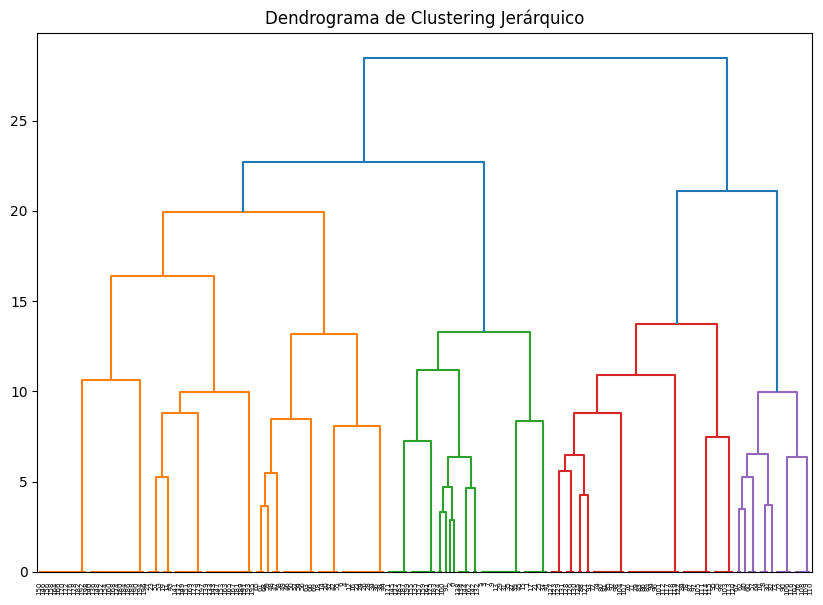

In [26]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma de Clustering Jerárquico')
plt.show()


In [39]:
# Decidir el número de clusters
n_clusters = 5

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

# Ajustar el modelo y predecir los clusters
labels = clustering.fit_predict(X_scaled)

# Asignar las etiquetas de cluster al DataFrame original para análisis
df_model['Cluster'] = labels

# Verificar el tamaño de cada cluster
print(df_model['Cluster'].value_counts())

# Explorar las características promedio de cada cluster
for i in range(n_clusters):
    print(f"\nCluster {i} characteristics:")
    # Calcula y muestra la media de las características para cada cluster
    print(df_model[df_model['Cluster'] == i].mean())


Cluster
0    48
2    42
1    34
5    28
4    28
3    20
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID               102.625000
Age                       38.520833
Gender_Female              0.541667
Gender_Male                0.458333
Age_Group_Young            0.291667
Age_Group_Adult            0.708333
Age_Group_Elder            0.000000
Income_Level_Low           0.000000
Income_Level_Medium        1.000000
Income_Level_High          0.000000
Spending_Level_Low         0.104167
Spending_Level_Medium      0.770833
Spending_Level_High        0.125000
Cluster                    0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID               41.647059
Age                      40.441176
Gender_Female             0.705882
Gender_Male               0.294118
Age_Group_Young           0.176471
Age_Group_Adult           0.823529
Age_Group_Elder           0.000000
Income_Level_Low          1.000000
Income_Level_Medium       0.000000
Income_Level_High         0.

C:\Users\memol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
# Decidir el número de clusters
n_clusters = 9

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

# Ajustar el modelo y predecir los clusters
labels = clustering.fit_predict(X_scaled)

# Asignar las etiquetas de cluster al DataFrame original para análisis
df_model['Cluster'] = labels

# Verificar el tamaño de cada cluster
print(df_model['Cluster'].value_counts())

# Explorar las características promedio de cada cluster
for i in range(n_clusters):
    print(f"\nCluster {i} characteristics:")
    # Calcula y muestra la media de las características para cada cluster
    print(df_model[df_model['Cluster'] == i].mean())


Cluster
2    34
5    28
1    28
0    24
3    20
7    18
8    18
4    16
6    14
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID               140.916667
Age                       25.583333
Gender_Female              0.500000
Gender_Male                0.500000
Age_Group_Young            1.000000
Age_Group_Adult            0.000000
Age_Group_Elder            0.000000
Income_Level_Low           0.083333
Income_Level_Medium        0.125000
Income_Level_High          0.791667
Spending_Level_Low         0.458333
Spending_Level_Medium      0.000000
Spending_Level_High        0.541667
Cluster                    0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID               170.928571
Age                       43.821429
Gender_Female              0.535714
Gender_Male                0.464286
Age_Group_Young            0.000000
Age_Group_Adult            1.000000
Age_Group_Elder            0.000000
Income_Level_Low           0.000000
Income_Level_Medium        0.00

C:\Users\memol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Medimos la silueta de coeficientes para `Kmeans` y `AgglomerativeClustering` para diferentes clusters.

In [29]:
silhouette_coefficients = []

for k in range(3, 11):
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

# Puedes imprimir los valores o graficarlos para verlos visualmente
silhouette_coefficients


[0.27426171376797703,
 0.288623875114939,
 0.3164969193881176,
 0.3449536607591422,
 0.36323417226115007,
 0.3883523523120152,
 0.41368690402654296,
 0.45805553672207766]

In [30]:
silhouette_coefficients_hierarchical = []

for k in range(3, 11):
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_coefficients_hierarchical.append(score)

# Imprimir los coeficientes de silueta para el clustering jerárquico
silhouette_coefficients_hierarchical


[0.22734263436238233,
 0.27204426605996895,
 0.29676461248523756,
 0.3221552862554259,
 0.33924716599559834,
 0.3724111099257578,
 0.4111873536188139,
 0.4386738426114282]

In [31]:
# Dividir el conjunto de datos en dos basados en el género
df_women = df_model[df_model['Gender_Female'] == True].copy()  
df_men = df_model[df_model['Gender_Male'] == True].copy()  

# Clustering para mujeres
kmeans_women = KMeans(n_clusters=5, n_init=10, random_state=42)
df_women['Cluster'] = kmeans_women.fit_predict(df_women[['Age_Group_Young', 'Age_Group_Adult',
                                                        'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
                                                        'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
                                                        'Spending_Level_High']])

# Clustering para hombres
kmeans_men = KMeans(n_clusters=5, n_init=10, random_state=42)
df_men['Cluster'] = kmeans_men.fit_predict(df_men[['Age_Group_Young', 'Age_Group_Adult',
                                                    'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
                                                    'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
                                                    'Spending_Level_High']])

print("Mujeres por Cluster:")
print(df_women.groupby('Cluster').mean())

print("\nHombres por Cluster:")
print(df_men.groupby('Cluster').mean())


Mujeres por Cluster:
         CustomerID        Age  Gender_Female  Gender_Male  Age_Group_Young  \
Cluster                                                                       
0         39.407407  44.888889            1.0          0.0         0.000000   
1         98.758621  40.724138            1.0          0.0         0.344828   
2        159.954545  32.272727            1.0          0.0         0.318182   
3        160.894737  42.105263            1.0          0.0         0.105263   
4         28.200000  24.266667            1.0          0.0         1.000000   

         Age_Group_Adult  Age_Group_Elder  Income_Level_Low  \
Cluster                                                       
0               0.888889         0.111111               1.0   
1               0.482759         0.172414               0.0   
2               0.681818         0.000000               0.0   
3               0.894737         0.000000               0.0   
4               0.000000         0.000000      

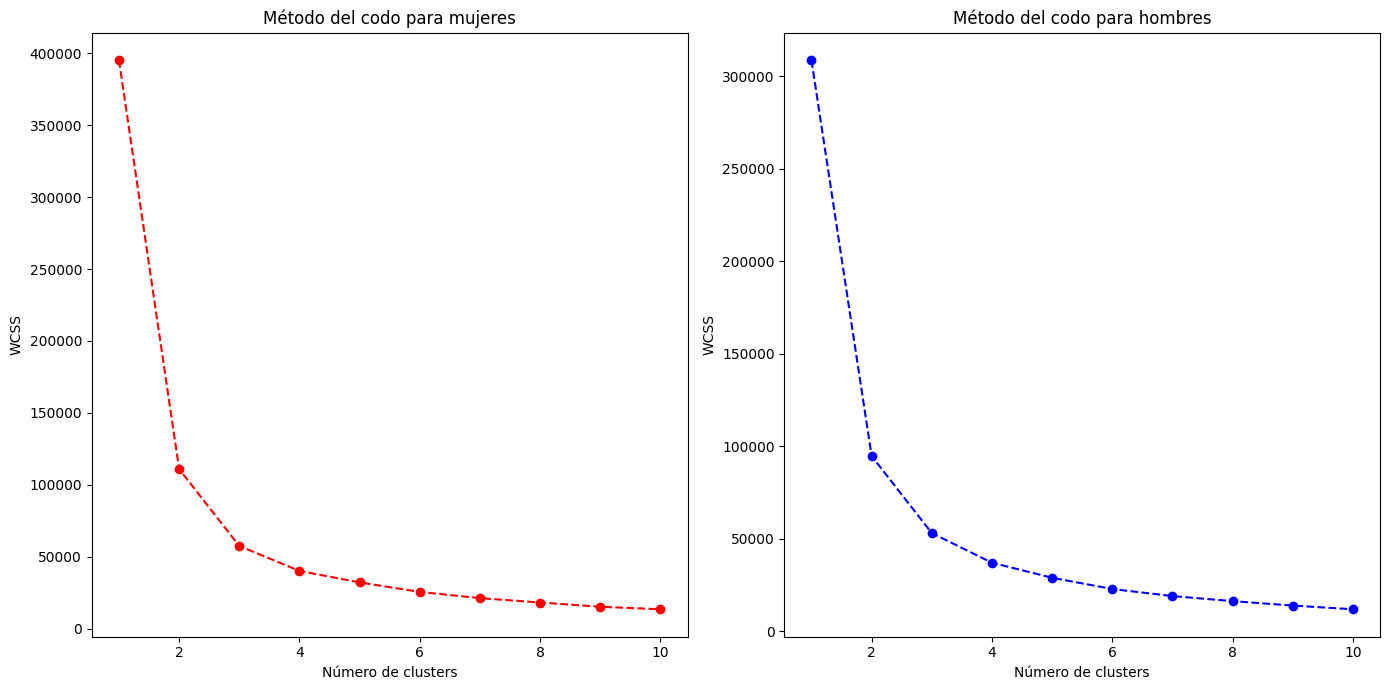

In [32]:
# Método del codo para mujeres
wcss_women = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_women)
    wcss_women.append(kmeans.inertia_)

# Método del codo para hombres
wcss_men = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_men)
    wcss_men.append(kmeans.inertia_)

# Graficar los resultados del método del codo
plt.figure(figsize=(14, 7))

# Gráfico para mujeres
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), wcss_women, marker='o', linestyle='--', color='red')
plt.title('Método del codo para mujeres')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

# Gráfico para hombres
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), wcss_men, marker='o', linestyle='--', color='blue')
plt.title('Método del codo para hombres')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

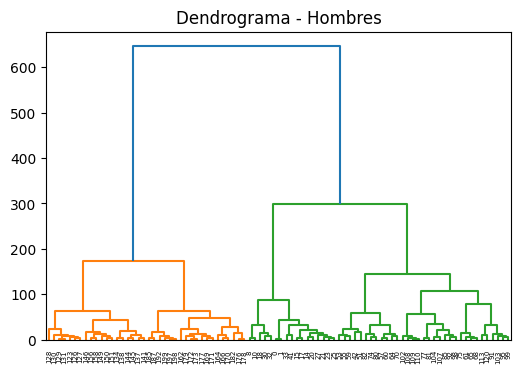

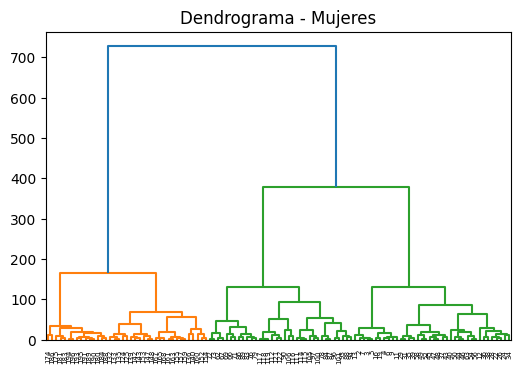

In [33]:
distance_matrix_men = linkage(df_men, method='ward')
distance_matrix_women = linkage(df_women, method='ward')

plt.figure(figsize=(6, 4))
dendrogram(distance_matrix_men, labels=df_men.index)
plt.title('Dendrograma - Hombres')
plt.show()

plt.figure(figsize=(6, 4))
dendrogram(distance_matrix_women, labels=df_women.index)
plt.title('Dendrograma - Mujeres')
plt.show()



In [34]:
# Para mujeres con 3 clusters
kmeans_women = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_women = kmeans_women.fit_predict(df_women)
df_women = df_women.copy() 
df_women.loc[:, 'Cluster'] = clusters_women

# Para hombres con 4 clusters
kmeans_men = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_men = kmeans_men.fit_predict(df_men)
df_men = df_men.copy() 
df_men.loc[:, 'Cluster'] = clusters_men


print("Tamaño de cada cluster para mujeres:")
print(df_women['Cluster'].value_counts())

print("\nTamaño de cada cluster para hombres:")
print(df_men['Cluster'].value_counts())


Tamaño de cada cluster para mujeres:
Cluster
0    38
2    37
1    37
Name: count, dtype: int64

Tamaño de cada cluster para hombres:
Cluster
0    27
2    24
1    19
3    18
Name: count, dtype: int64


In [35]:
# Estadísticas descriptivas para los clusters de mujeres
cluster_stats_women = df_women.groupby('Cluster').mean()
print("Estadísticas de los Clusters para Mujeres:")
cluster_stats_women


Estadísticas de los Clusters para Mujeres:


,CustomerID,Age,Gender_Female,Gender_Male,Age_Group_Young,Age_Group_Adult,Age_Group_Elder,Income_Level_Low,Income_Level_Medium,Income_Level_High,Spending_Level_Low,Spending_Level_Medium,Spending_Level_High
Cluster,,,,,,,,,,,,,
0,95.447368,41.789474,1.0,0.0,0.263158,0.552632,0.184211,0.131579,0.868421,0.0,0.105263,0.842105,0.052632
1,166.081081,36.945946,1.0,0.0,0.243243,0.756757,0.000000,0.000000,0.000000,1.0,0.459459,0.000000,0.540541
2,31.216216,35.459459,1.0,0.0,0.405405,0.567568,0.027027,1.000000,0.000000,0.0,0.378378,0.243243,0.378378


In [36]:
# Estadísticas descriptivas para los clusters de hombres
cluster_stats_men = df_men.groupby('Cluster').mean()
print("Estadísticas de los Clusters para Hombres:")
cluster_stats_men


Estadísticas de los Clusters para Hombres:


,CustomerID,Age,Gender_Female,Gender_Male,Age_Group_Young,Age_Group_Adult,Age_Group_Elder,Income_Level_Low,Income_Level_Medium,Income_Level_High,Spending_Level_Low,Spending_Level_Medium,Spending_Level_High
Cluster,,,,,,,,,,,,,
0,171.222222,36.333333,0.0,1.0,0.296296,0.703704,0.000000,0.000000,0.000000,1.000000,0.555556,0.000000,0.444444
1,69.894737,47.526316,0.0,1.0,0.210526,0.526316,0.263158,0.526316,0.473684,0.000000,0.105263,0.789474,0.105263
2,117.791667,39.958333,0.0,1.0,0.333333,0.500000,0.166667,0.000000,0.833333,0.166667,0.250000,0.500000,0.250000
3,21.944444,36.666667,0.0,1.0,0.444444,0.388889,0.166667,1.000000,0.000000,0.000000,0.500000,0.000000,0.500000


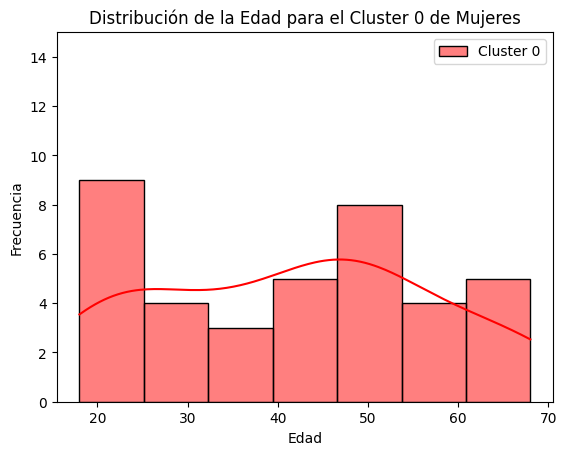

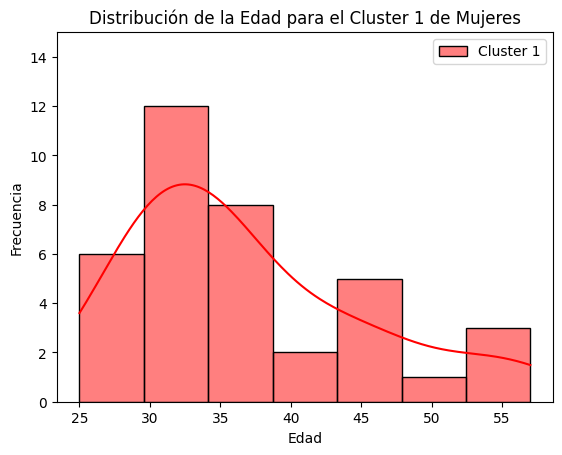

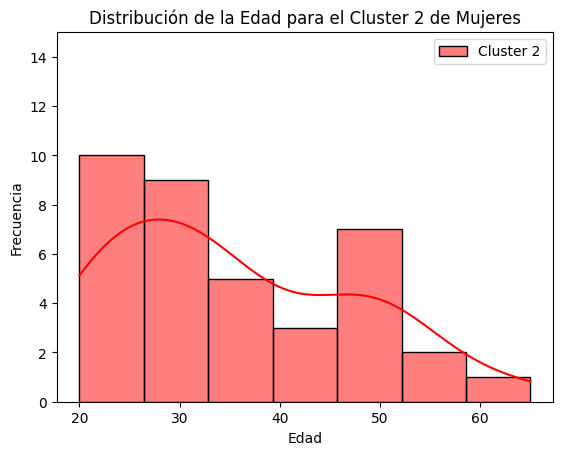

In [37]:
# Histogramas para la edad en los clusters de mujeres
num_clusters_women = df_women['Cluster'].nunique()  # Obtiene el número único de clusters

for i in range(num_clusters_women):
    plt.figure()  # Crea una nueva figura para cada histograma
    sns.histplot(df_women[df_women['Cluster'] == i]['Age'], kde=True, label=f'Cluster {i}', color='red')
    plt.title(f'Distribución de la Edad para el Cluster {i} de Mujeres')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.ylim(0, 15)
    plt.show()

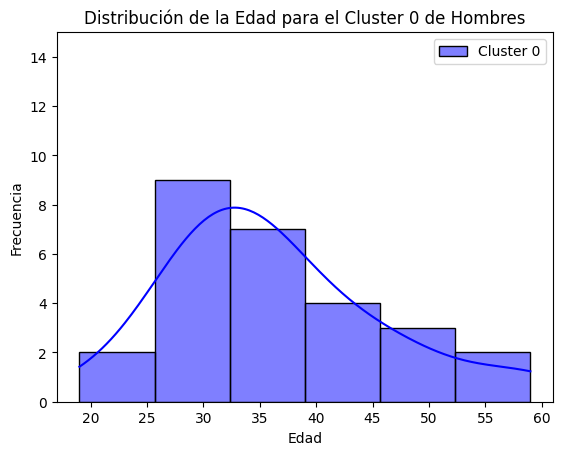

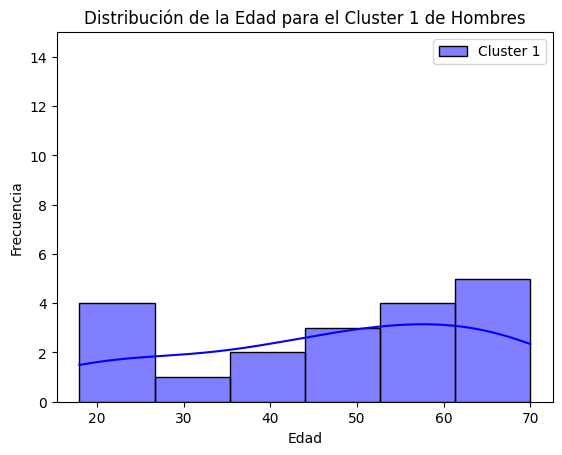

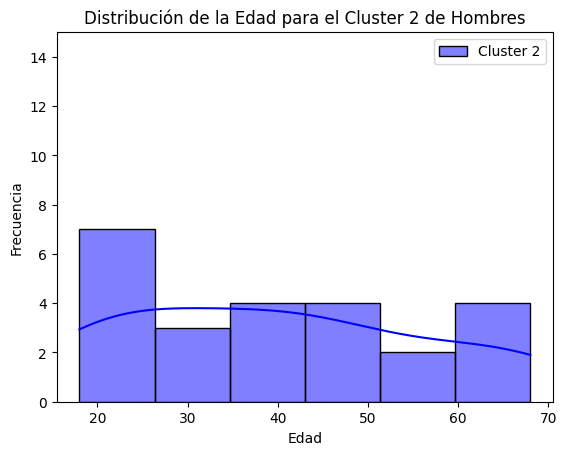

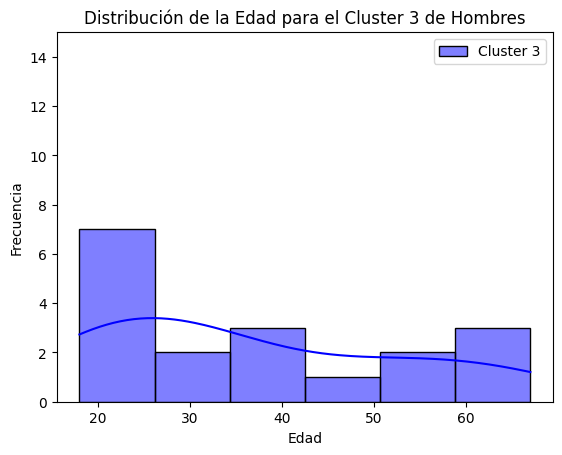

In [38]:
# Histogramas para la edad en los clusters de mujeres
num_clusters_men = df_men['Cluster'].nunique()  # Obtiene el número único de clusters

for i in range(num_clusters_men):
    plt.figure()  # Crea una nueva figura para cada histograma
    sns.histplot(df_men[df_men['Cluster'] == i]['Age'], kde=True, label=f'Cluster {i}', color='blue')
    plt.title(f'Distribución de la Edad para el Cluster {i} de Hombres')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.ylim(0, 15)
    plt.show()

## Conclusiones:

`df_women`: La segmentación de las clientas me cuenta que para:

Cluster 0:

Características Promedio: Edad aproximada de 42 años. Este grupo se caracteriza por una distribución mixta en términos de grupos de edad, pero con una ligera inclinación hacia las edades adultas y jóvenes. La mayoría tiene ingresos altos, ya que casi el 87% pertenece a este grupo de ingreso. Respecto a los niveles de gasto, una gran mayoría muestra un nivel de gasto alto.

Estrategia de Ventas: Este grupo podría ser el objetivo para productos premium o de lujo, considerando sus altos ingresos y su disposición a gastar. Las campañas de marketing deben enfocarse en productos de alta calidad o servicios exclusivos que apelen a sus estilos de vida sofisticados y a su capacidad económica.

Cluster 1:

Características Promedio: Edad promedio de unos 37 años, con una marcada preferencia por la juventud y la adultez. Este segmento se distingue por tener ingresos bajos, ya que el 100% se clasifica en este nivel. En cuanto a los gastos, hay una notable tendencia hacia el gasto bajo, aunque una porción significativa también muestra gasto alto.

Estrategia de Ventas: Dado su menor nivel de ingreso, este grupo podría estar más interesado en productos asequibles y de buen valor. Las estrategias de marketing podrían enfocarse en destacar la calidad-precio de los productos o servicios, ofertas especiales, descuentos y programas de lealtad.

Cluster 2:

Características Promedio: Edad promedio de unos 35 años, con una inclinación hacia los grupos de edad joven y adulto. Todos en este grupo tienen ingresos bajos. Los niveles de gasto están equilibrados entre bajo, medio y alto, lo que indica una diversidad en sus hábitos de consumo.

Estrategia de Ventas: Este segmento representa a consumidoras jóvenes y de ingresos bajos con variados patrones de gasto. Las estrategias podrían centrarse en productos económicos pero también en artículos de moda o tendencia que apelen a su deseo de estar al día, sin sobrepasar su presupuesto. Las campañas digitales, ofertas por tiempo limitado y las opciones de pago flexibles pueden ser particularmente atractivas para este grupo.

`df_men`: Y para los hombres:

Cluster 0:

Características Promedio: Edad promedio de aproximadamente 36 años, con una mayoría en el grupo de edad adulto. Todos los individuos en este grupo tienen ingresos bajos y tienden a tener un nivel de gasto bajo, aunque una proporción significativa también muestra un nivel de gasto alto.

Estrategia de Ventas: Este grupo podría ser objetivo para productos y servicios asequibles. Considerando su limitación de ingresos, las campañas deben enfocarse en la relación calidad-precio y en ofertas especiales. Este grupo podría responder bien a las promociones de productos que combinan funcionalidad y buen precio.

Cluster 1:

Características Promedio: Edad promedio de alrededor de 48 años, con una distribución más uniforme entre los grupos de edad, incluyendo una representación notable de mayores. Este grupo tiene una mezcla de niveles de ingresos bajos y medios y muestra una fuerte tendencia hacia el gasto medio.

Estrategia de Ventas: Dado que este segmento incluye una gama más amplia de edades y una tendencia hacia el gasto medio, las estrategias de marketing podrían enfocarse en productos que ofrezcan valor y durabilidad. Las campañas deben resaltar la calidad y la utilidad a largo plazo, posiblemente con un enfoque en la salud, el bienestar y la inversión a largo plazo.

Cluster 2:

Características Promedio: Edad promedio cercana a los 40 años, con una distribución equilibrada entre jóvenes y adultos. Este grupo se distingue por tener altos ingresos, con una tendencia a gastar en un nivel medio.

Estrategia de Ventas: Este segmento, con su alto nivel de ingresos y gasto moderado, podría estar interesado en productos de gama media a alta. Las estrategias podrían incluir la promoción de bienes duraderos, tecnología avanzada o servicios exclusivos que ofrezcan un valor distintivo. Es probable que este grupo valore la innovación, la calidad y el estatus.

Cluster 3:

Características Promedio: Edad promedio de alrededor de 37 años, con una distribución ligeramente inclinada hacia los más jóvenes y los adultos. Este grupo tiene ingresos bajos y muestra una división equitativa entre los niveles de gasto bajo y alto.

Estrategia de Ventas: Este grupo presenta un desafío y una oportunidad: aunque tienen ingresos bajos, están dispuestos a gastar en ciertas categorías. Las estrategias de marketing deberían centrarse en productos de valor que apelen a sus intereses y necesidades específicas, potencialmente en áreas como entretenimiento, moda asequible o tecnología de bajo costo. Las promociones, descuentos y facilidades de pago pueden ser especialmente atractivos para este segmento.